# DataCamp Certification Case Study

### Project Brief

You have been hired by Inn the Neighborhood, an online platform that allows people to rent out their properties for short stays. Currently, the webpage for renters has a conversion rate of 2%. This means that most people leave the platform without signing up. 

The product manager would like to increase this conversion rate. They are interested in developing an application to help people estimate the money they could earn renting out their living space. They hope that this would make people more likely to sign up.

The company has provided you with a dataset that includes details about each property rented, as well as the price charged per night. They want to avoid estimating prices that are more than 25 dollars off of the actual price, as this may discourage people.

You will need to present your findings in two formats:
- You must submit a written report summarising your analysis to your manager. As a data science manager, your manager has a strong technical background and wants to understand what you have done and why. 
- You will then need to share your findings with the product manager in a 10 minute presentation. The product manager has no data science background but is familiar with basic data related terminology. 

The data you will use for this analysis can be accessed here: `"data/rentals.csv"`

<font size="+2" color="black"><b>Table of Contents</b></font><br>
* 1 - Importing Libraries
* 2 - Reading Data 
* 3 - Data Visualization
* 4 - Data Processing
* 5 - Feature Engineering
* 6 - Modelling
* 7 - Interpreting results

<font color='black' size="+2.5"><b>1 - Libraries</b></font><br><a id='1'></a>

In [75]:
#import libraries
import pickle
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from xgboost import XGBRegressor
from xgboost import plot_importance
import xgboost
from sklearn.model_selection import GridSearchCV
import time
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
sns.set()

#declare paths
data_path = "data/rentals.csv"

<a id="2"></a> <br>
<font color='black' size="+2.5"><b>2 - Reading Data</b></font><br>

### 2.1 Reading Data

In [2]:
data = pd.read_csv(data_path, index_col=0)

### 2.2 Understanding our data

In [3]:
data.head()

latitude  longitude property_type        room_type  bathrooms  bedrooms  \
id                                                                              
958   37.76931 -122.43386     Apartment  Entire home/apt        1.0       1.0   
3850  37.75402 -122.45805         House     Private room        1.0       1.0   
5858  37.74511 -122.42102     Apartment  Entire home/apt        1.0       2.0   
7918  37.76669 -122.45250     Apartment     Private room        4.0       1.0   
8142  37.76487 -122.45183     Apartment     Private room        4.0       1.0   

      minimum_nights     price  
id                              
958                1  $170.00   
3850               1   $99.00   
5858              30  $235.00   
7918              32   $65.00   
8142              32   $65.00

As we see from the below results of **info** method there are:

- 4 null values in bedrooms
- 12 null values in bathrooms

Also price is read as an object, which is reasonable since there is the dollar sign in front of the number.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8111 entries, 958 to 39354181
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   latitude        8111 non-null   float64
 1   longitude       8111 non-null   float64
 2   property_type   8111 non-null   object 
 3   room_type       8111 non-null   object 
 4   bathrooms       8099 non-null   float64
 5   bedrooms        8107 non-null   float64
 6   minimum_nights  8111 non-null   int64  
 7   price           8111 non-null   object 
dtypes: float64(4), int64(1), object(3)
memory usage: 570.3+ KB


### 2.3 Convert price to correct type

Now we will use regex to keep only the numbers from the price and then convert the column to numeric.
But first we will replace comma (,) with empty string because it affects the encoding.

Also, we will change minimum_nights from int64 to float too

In [5]:
data['price'] = data.price.str.replace(',','')
data['price'] = data.price.str.extract(r'(\d+.\d+)').astype('float')

In [6]:
data['minimum_nights'] = data['minimum_nights'].astype('float')

In [7]:
data.head()

latitude  longitude property_type        room_type  bathrooms  bedrooms  \
id                                                                              
958   37.76931 -122.43386     Apartment  Entire home/apt        1.0       1.0   
3850  37.75402 -122.45805         House     Private room        1.0       1.0   
5858  37.74511 -122.42102     Apartment  Entire home/apt        1.0       2.0   
7918  37.76669 -122.45250     Apartment     Private room        4.0       1.0   
8142  37.76487 -122.45183     Apartment     Private room        4.0       1.0   

      minimum_nights  price  
id                           
958              1.0  170.0  
3850             1.0   99.0  
5858            30.0  235.0  
7918            32.0   65.0  
8142            32.0   65.0

Below we can observe the descriptive statistics of our numerical columns except long, lat because it represents geographical data.
Most houses vary from 1 to 2 bathrooms and bedrooms. Although, it is interesting that there is a house with 14 bathrooms and bedrooms but also a house without bathrooms and bedrooms. 

The price and minimum nights seem to have plenty of outliers. This is obvious by looking at their mean value and their median. Also their standard deviation is very high.

In [8]:
data[['bathrooms', 'bedrooms', 'minimum_nights', 'price']].describe()

bathrooms     bedrooms  minimum_nights         price
count  8099.000000  8107.000000    8.111000e+03   8111.000000
mean      1.395975     1.345874    1.234526e+04    225.407101
std       0.923213     0.925298    1.110357e+06    412.253039
min       0.000000     0.000000    1.000000e+00      0.000000
25%       1.000000     1.000000    2.000000e+00    100.000000
50%       1.000000     1.000000    4.000000e+00    150.000000
75%       1.500000     2.000000    3.000000e+01    240.000000
max      14.000000    14.000000    1.000000e+08  10000.000000

We see that there is a huge outlier based on minimum nights that says you need to stay to the apartment around 1 million days. 
We drop it so that it does not affect our analysis

In [9]:
data = data.loc[data['minimum_nights'] < data['minimum_nights'].max()]

Now minimum nights seems more reasonable. The max nights to stay is 1125 which still is big number enough. But maybe some luxury place can hold it.

In [10]:
data[['minimum_nights']].describe()

minimum_nights
count     8110.000000
mean        16.328113
std         27.650693
min          1.000000
25%          2.000000
50%          4.000000
75%         30.000000
max       1125.000000

We see that the price of this apartment is very high. Our case study focuses mostly on apartments that are approachable by people of normal annual salary. Probably we will need to drop it later when we build our predictive model. But we will keep it for now. 

The value seems to be wrong for a not luxury property with only 2 bathrooms and 1 bedroom. But later on outlier detection we will clean all these rows.

In [11]:
data.loc[data['minimum_nights'] == data['minimum_nights'].max()]

latitude  longitude property_type     room_type  bathrooms  bedrooms  \
id                                                                              
8066789  37.76264 -122.42082     Apartment  Private room        2.0       1.0   

         minimum_nights   price  
id                               
8066789          1125.0  3200.0

Here we show the descriptive statistics of our categorical columns

In [12]:
data[['property_type', 'room_type']].describe()

property_type        room_type
count           8110             8110
unique            26                4
top        Apartment  Entire home/apt
freq            3242             4772

### 2.4 Clean Data

Remove rows that are impossible to exist. Such as rows with price or bathroom equal to 0. 

Apartments need to have at least 1 bathroom to be rented.

Bedrooms probably can be >= 0 but not less.

In [13]:
data = data[(data.bathrooms > 0)]
data = data[(data.bedrooms >= 0)]
data = data[(data.price>1)] 
data = data[(data.minimum_nights>1)]

Drop rows with bedrooms or bathrooms that have a float number such as 2.5 etc..

In [14]:
data = data[[value.is_integer() for value in data.bathrooms.values]] 
data = data[[value.is_integer() for value in data.bedrooms.values]] 

### 2.5 Missing Data

In [15]:
data.isnull().sum()

latitude          0
longitude         0
property_type     0
room_type         0
bathrooms         0
bedrooms          0
minimum_nights    0
price             0
dtype: int64

<a id="3"></a> <br>
<font size="+2.5"><b>3 - Data Visualization</b></font><br>

In this section:

- 3.1 Viewing Columns

- 3.2 Distribution of Data

- 3.3 Univariate Analysis of Data

- 3.4 Bivariate Analysis of Data

### 3.1 Viewing Columns

In [16]:
numerical_features = data.select_dtypes(exclude=['object']).drop(['price', 'longitude', 'latitude'], axis=1).copy()
print(f"numerical feature columns are: {numerical_features.columns} \n target column is: price")

numerical feature columns are: Index(['bathrooms', 'bedrooms', 'minimum_nights'], dtype='object') 
 target column is: price


In [17]:
categorical_features = data.select_dtypes(include=['object']).copy()
print(f"categorical feature columns are: {categorical_features.columns} ")

categorical feature columns are: Index(['property_type', 'room_type'], dtype='object') 


In [18]:
print(f"geographical  columns that represent coordinates are: longitude and latitude ")

geographical  columns that represent coordinates are: longitude and latitude 


### 3.2 Distribution of Data

#### 3.2.1 Numerical

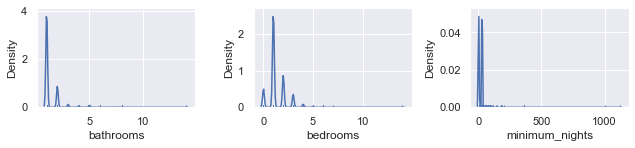

In [19]:
fig = plt.figure(figsize=(12,18))
for i in range(len(numerical_features.columns)):
    fig.add_subplot(9,4,i+1)
    sns.distplot(numerical_features.iloc[:,i].dropna(), rug=True, hist=False, label='UW', kde_kws={'bw':0.1})
    plt.xlabel(numerical_features.columns[i])
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='price', ylabel='Density'>

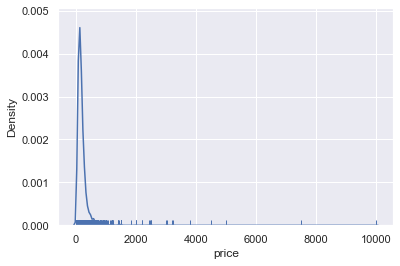

In [20]:
#target column
sns.distplot(data['price'], rug=True, hist=False, label='UW', kde_kws={'bw':0.1})

#### 3.2.2 categorical

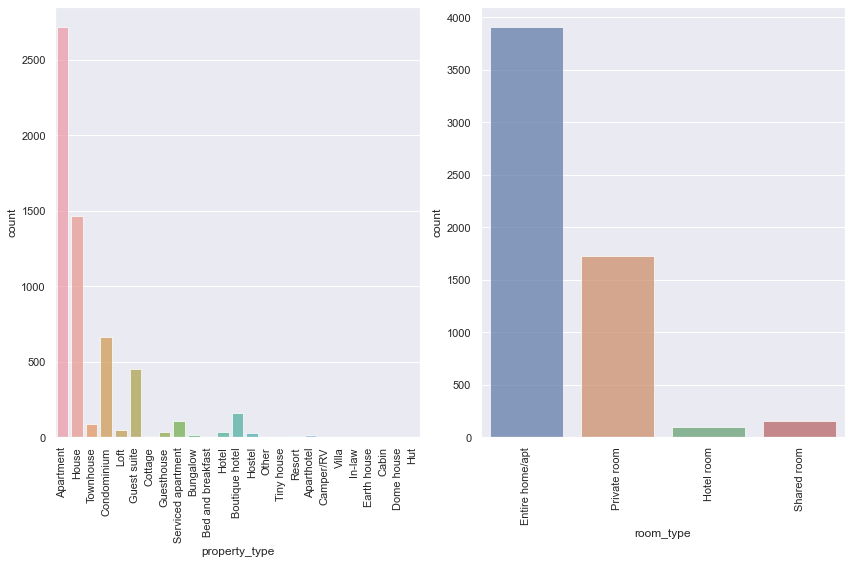

In [21]:
static_data_id_to_cat = data[[col for col in data.columns if (data[col].dtype=="O" )]].astype(str)
cat_df = static_data_id_to_cat.select_dtypes(include = ['object'])
columns_to_iterate = [col for col in cat_df.columns if 'ID' not in col]
fig, axes = plt.subplots(round(len(columns_to_iterate) / 2), 2, figsize=(12, 8))
for i, ax in enumerate(fig.axes):
    if i < len(columns_to_iterate):
        ax.xaxis.set_major_locator(mticker.MaxNLocator(3))
        ticks_loc = ax.get_xticks().tolist()
        ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
        ax.set_xticklabels(ticks_loc, rotation=90)
        sns.countplot(x=columns_to_iterate[i], alpha=0.7, data=cat_df, ax=ax)
fig.tight_layout()
plt.show() 

### 3.3 Univariate Analysis

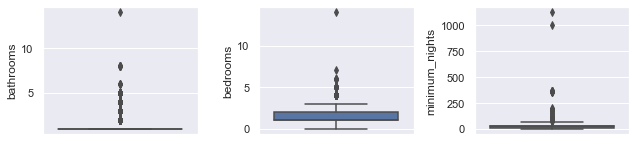

In [22]:
fig = plt.figure(figsize=(12,18))
for i in range(len(numerical_features.columns)):
    fig.add_subplot(9,4,i+1)
    sns.boxplot(y=numerical_features.iloc[:,i])

plt.tight_layout()
plt.show()

### 3.4 Bivariate Analysis

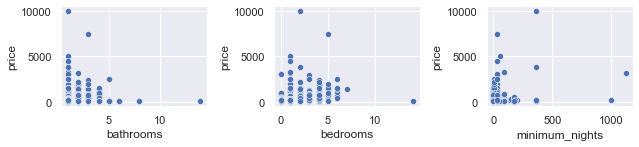

In [23]:
fig = plt.figure(figsize=(12,18))
for i in range(len(numerical_features.columns)):
    fig.add_subplot(9, 4, i+1)
    sns.scatterplot(numerical_features.iloc[:, i],data['price'])
plt.tight_layout()
plt.show()

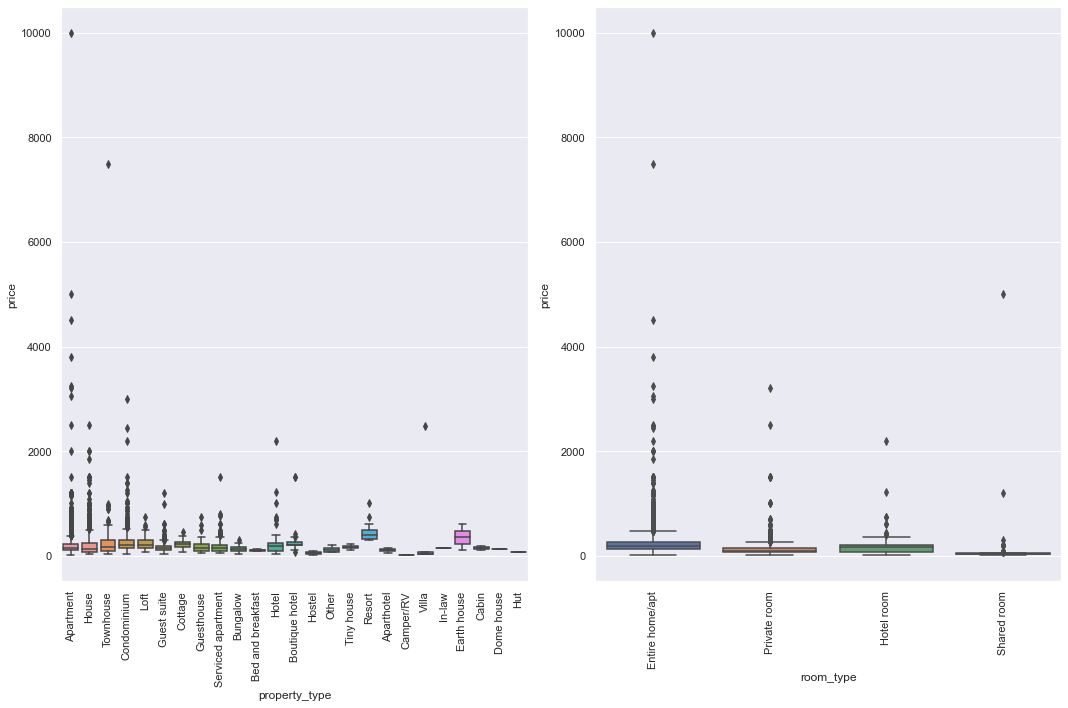

In [24]:
fig = plt.figure(figsize=(15,10))
for i in range(len(categorical_features.columns)):
    fig.add_subplot(1, 2, i+1)
    sns.boxplot(data=data, x=categorical_features.columns[i], y="price")
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

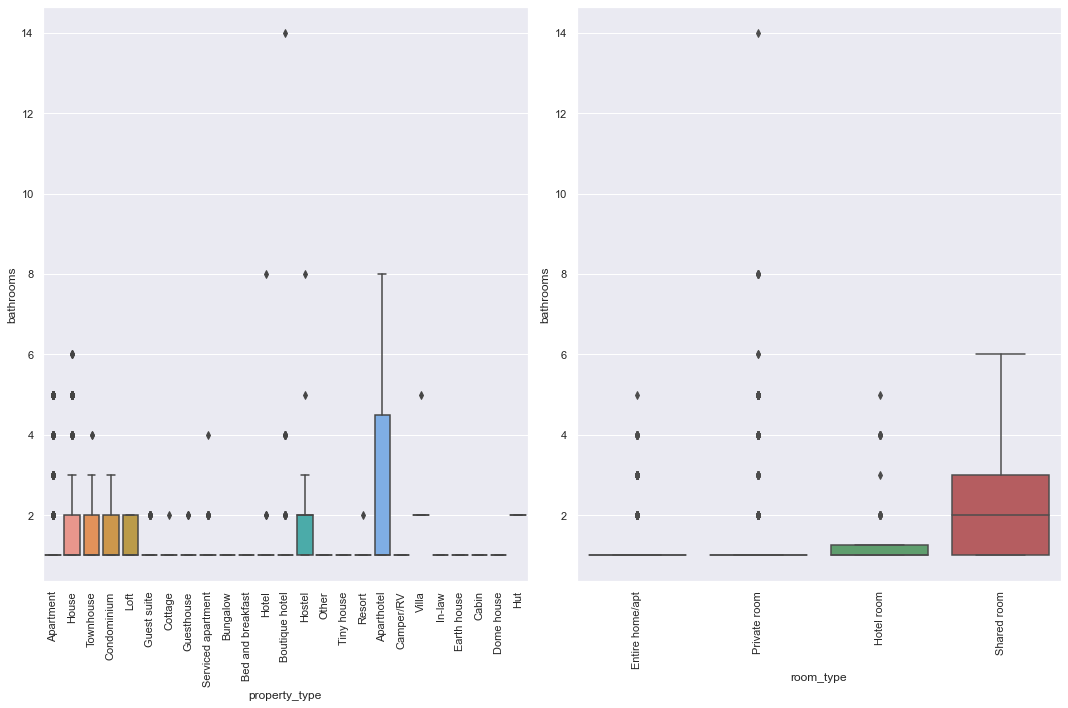

In [25]:
fig = plt.figure(figsize=(15,10))
for i in range(len(categorical_features.columns)):
    fig.add_subplot(1, 2, i+1)
    sns.boxplot(data=data, x=categorical_features.columns[i], y="bathrooms")
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

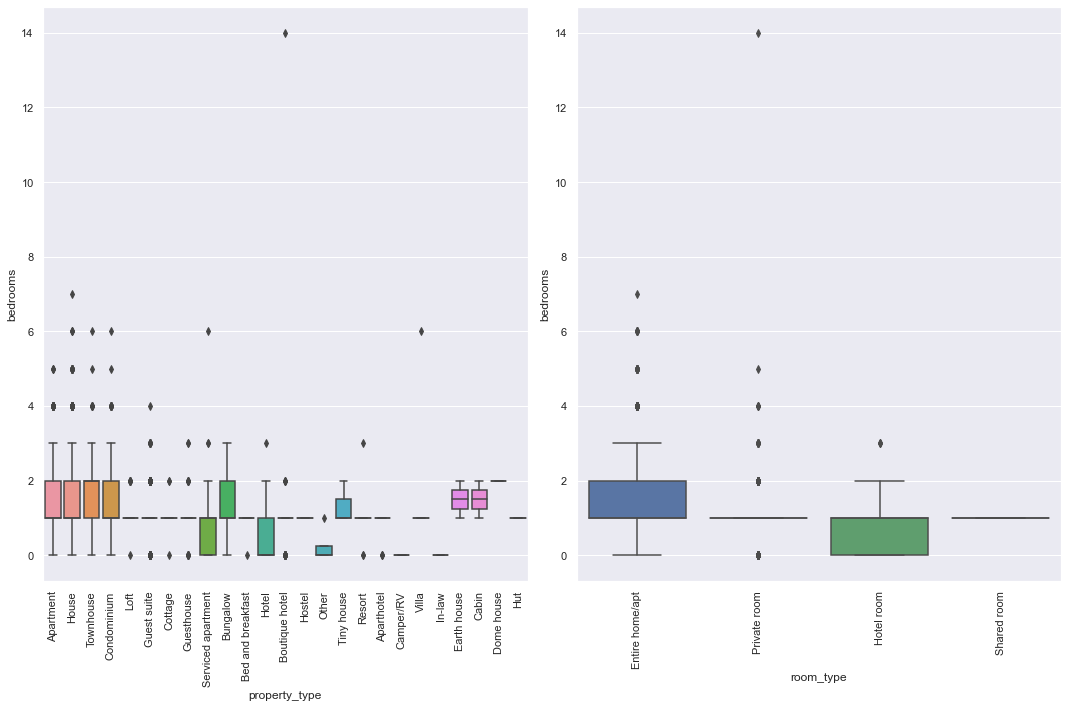

In [26]:
fig = plt.figure(figsize=(15,10))
for i in range(len(categorical_features.columns)):
    fig.add_subplot(1, 2, i+1)
    sns.boxplot(data=data, x=categorical_features.columns[i], y="bedrooms")
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

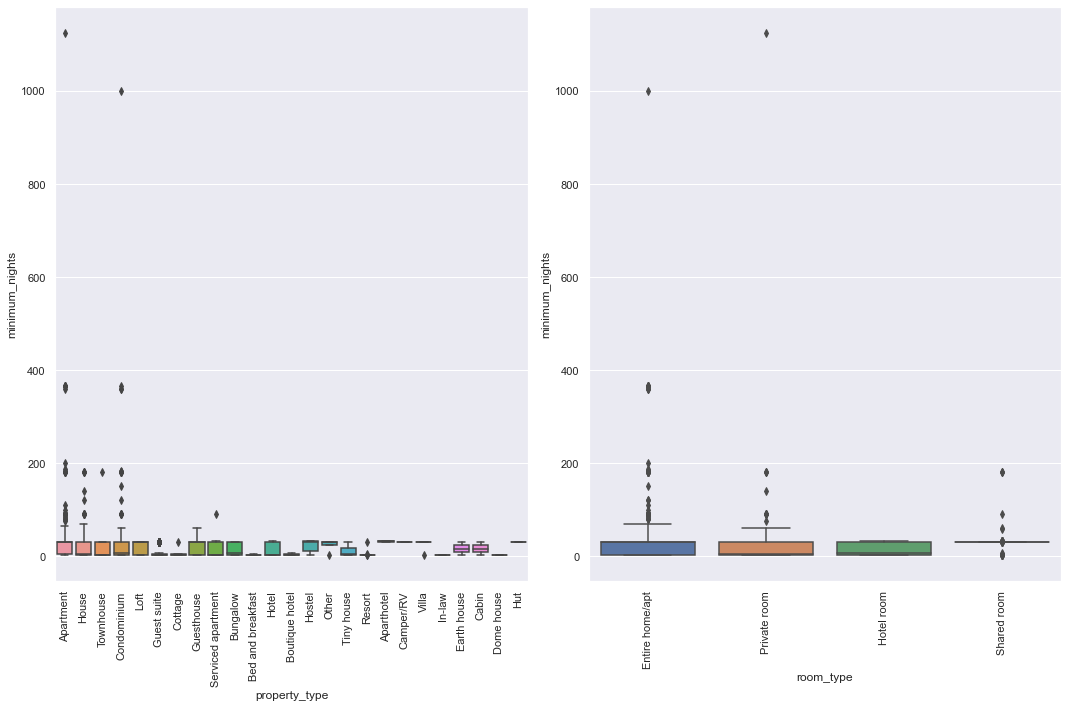

In [27]:
fig = plt.figure(figsize=(15,10))
for i in range(len(categorical_features.columns)):
    fig.add_subplot(1, 2, i+1)
    sns.boxplot(data=data, x=categorical_features.columns[i], y="minimum_nights")
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

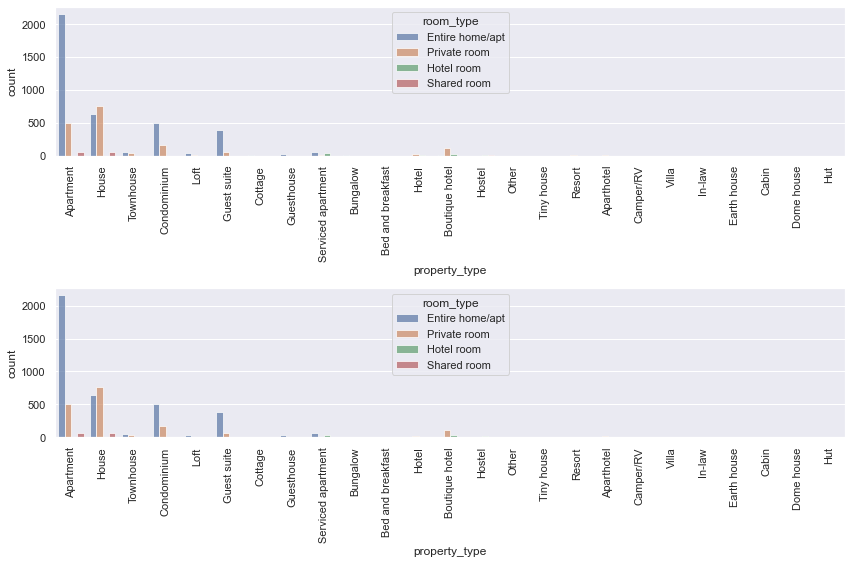

In [28]:
static_data_id_to_cat = data[[col for col in data.columns if (data[col].dtype=="O" )]].astype(str)
cat_df = static_data_id_to_cat.select_dtypes(include = ['object'])
columns_to_iterate = [col for col in cat_df.columns if 'ID' not in col]
fig, axes = plt.subplots(round(len(columns_to_iterate) / 1), 1, figsize=(12, 8))
for i, ax in enumerate(fig.axes):
    if i < len(columns_to_iterate):
        ax.xaxis.set_major_locator(mticker.MaxNLocator(3))
        ticks_loc = ax.get_xticks().tolist()
        ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
        ax.set_xticklabels(ticks_loc, rotation=90)
        sns.countplot(x='property_type', hue='room_type', alpha=0.7, data=cat_df, ax=ax)
fig.tight_layout()
plt.show()

<a id="4"></a> <br>
<font color='black' size="+2.5"><b>4 - OUTLIERS</b></font><br>

Notes on Outliers:
According to the plots above, these are the features which appear to have outliers:
- bathrooms
- bedrooms
- price
- minimum_nights

Let's take a closer look at these features...

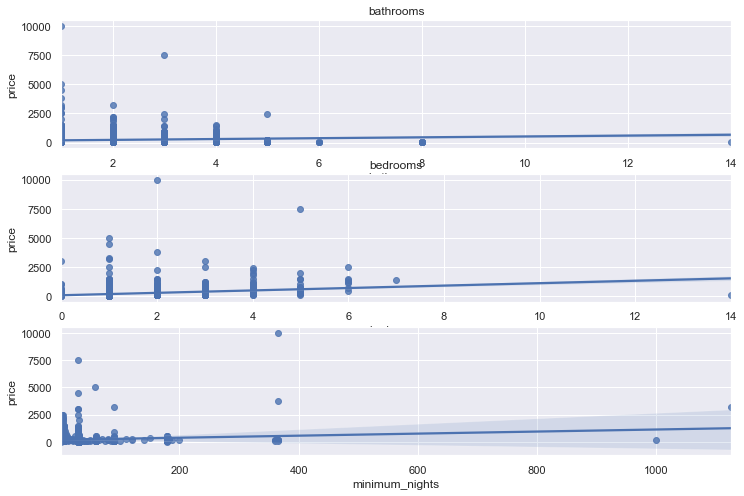

In [29]:
figure, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)
figure.set_size_inches(12, 8 )
_ = sns.regplot(data['bathrooms'], data['price'], ax=ax1).set_title('bathrooms')
_ = sns.regplot(data['bedrooms'], data['price'], ax=ax2).set_title('bedrooms')
_ = sns.regplot(data['minimum_nights'], data['price'], ax=ax3)



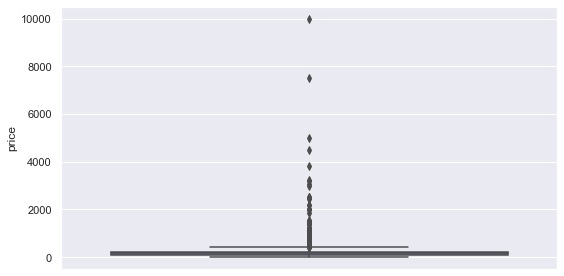

In [30]:
fig = plt.figure(figsize=(8,4))
sns.boxplot(data=data, y="price")
plt.tight_layout()
plt.show()

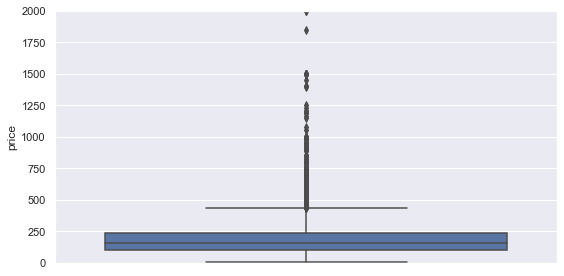

In [31]:
fig = plt.figure(figsize=(8,4))
sns.boxplot(data=data, y="price")
x1,x2,y1,y2 = plt.axis()  
plt.axis((x1,x2,0,2000))
plt.tight_layout()
plt.show()

### 4.1 Remove Outliers

In [32]:
data = data.drop(data[data['bedrooms']>6].index)
data = data.drop(data[data['bathrooms']>4].index)
data = data.drop(data[data['minimum_nights']>200].index)
data = data.drop(data[data['price']>250].index)

In [33]:
len(data)

4579

### 4.2 Correlated Features

No correlated features were found

<AxesSubplot:title={'center':'High Correlation'}>

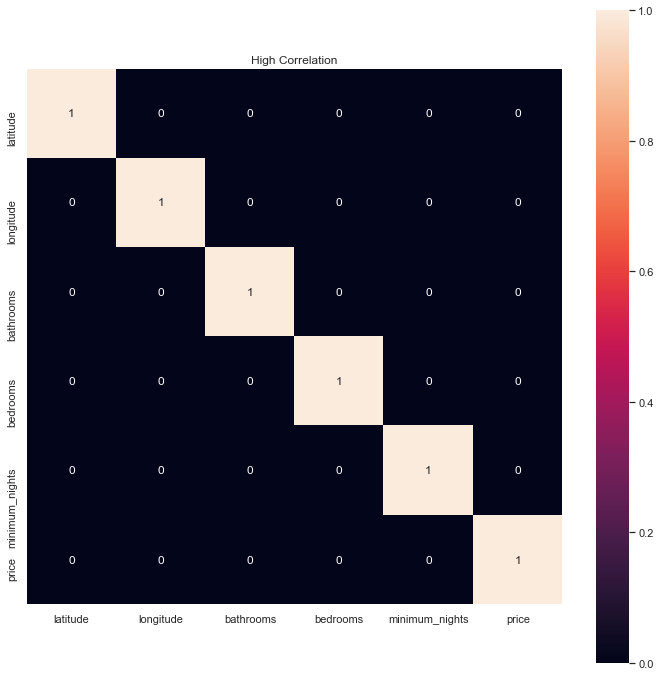

In [34]:
num_correlation = data.select_dtypes(exclude='object').corr()
plt.figure(figsize=(12,12))
plt.title('High Correlation')
sns.heatmap(num_correlation > 0.8, annot=True, square=True)

<a id="5"></a> <br>
<font color='black' size="+2.5"><b>5 - Feature Engineering</b></font><br>

Steps:

- Kmeans Clustering in lon, lat and assign labels to neighborhood's areas
- Group property types such as (camper/RV,  In-law, Earth house, Dome house, Hut, Bed and breakfast) to "others" 
- make dummy variables in property_type
- make dummy variables in room_type


### 5.1 KMeans and silhouette method

After seeing the silhouette plots, we observe that for K = 12 we have similar thickness and size between the clusters. Also, all clusters seem to be on the average silhouette score.

For n_clusters = 2 The average silhouette_score is : 0.42027384075776225
For n_clusters = 3 The average silhouette_score is : 0.41295838387304534
For n_clusters = 4 The average silhouette_score is : 0.39278036484639073
For n_clusters = 5 The average silhouette_score is : 0.4257229164765525
For n_clusters = 6 The average silhouette_score is : 0.3961316286189417
For n_clusters = 8 The average silhouette_score is : 0.37723418560492195
For n_clusters = 10 The average silhouette_score is : 0.37189568647697274
For n_clusters = 12 The average silhouette_score is : 0.38862423476892477


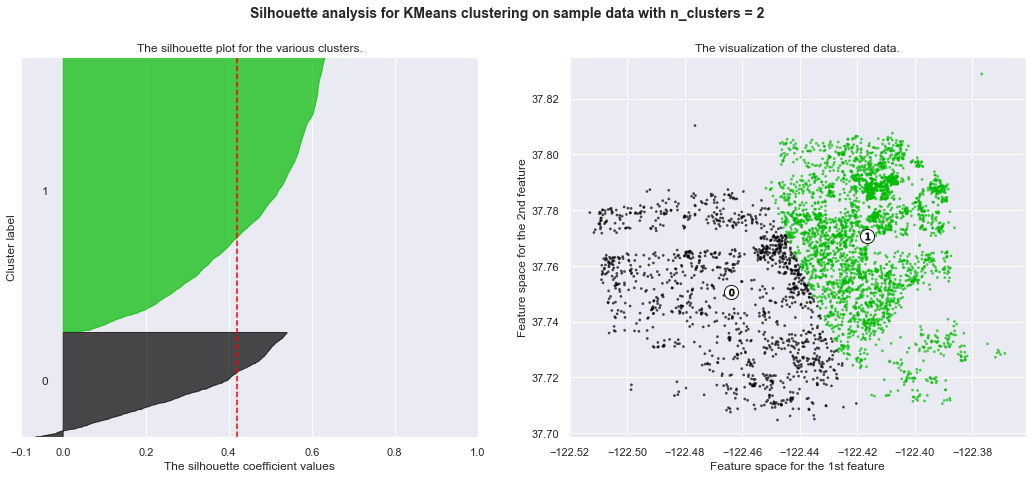

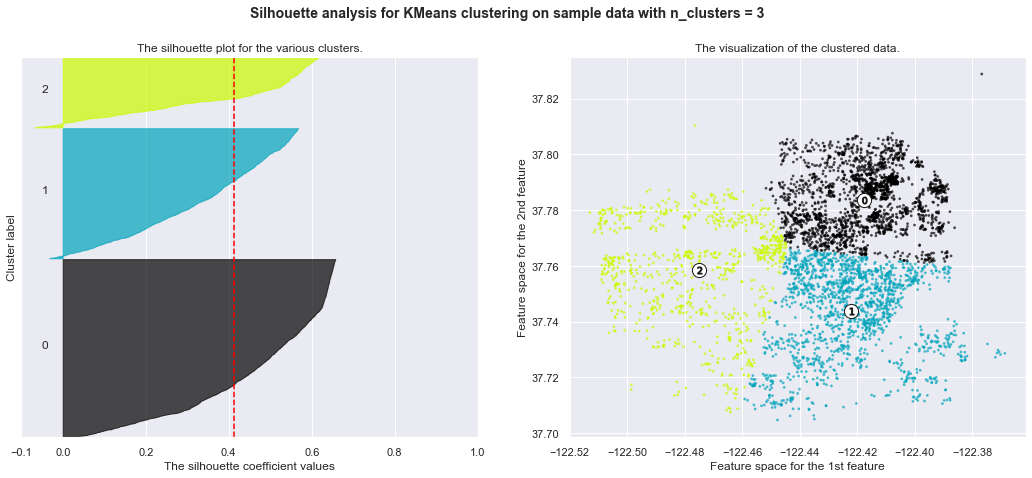

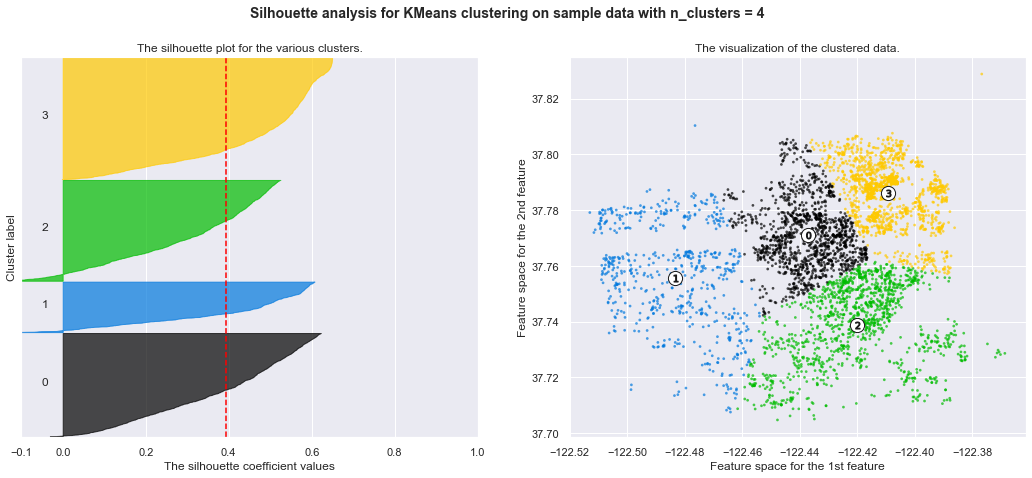

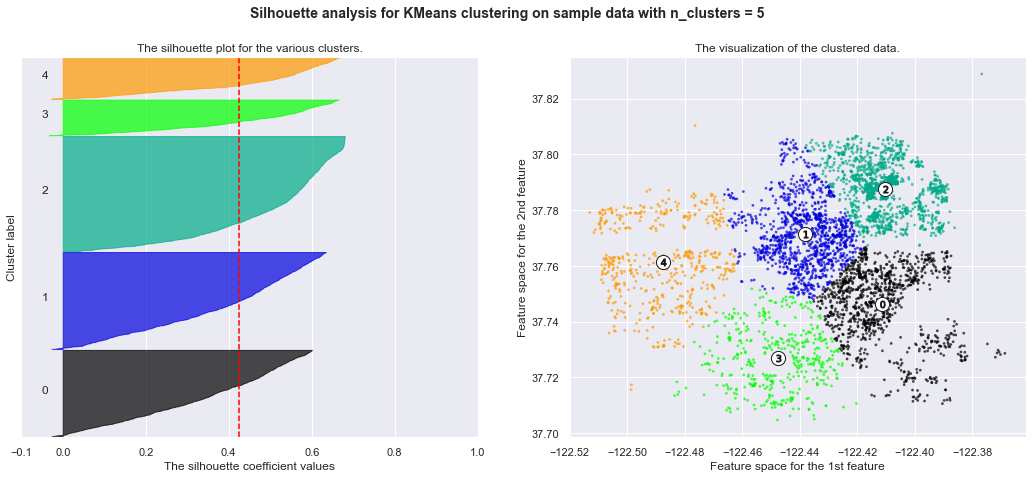

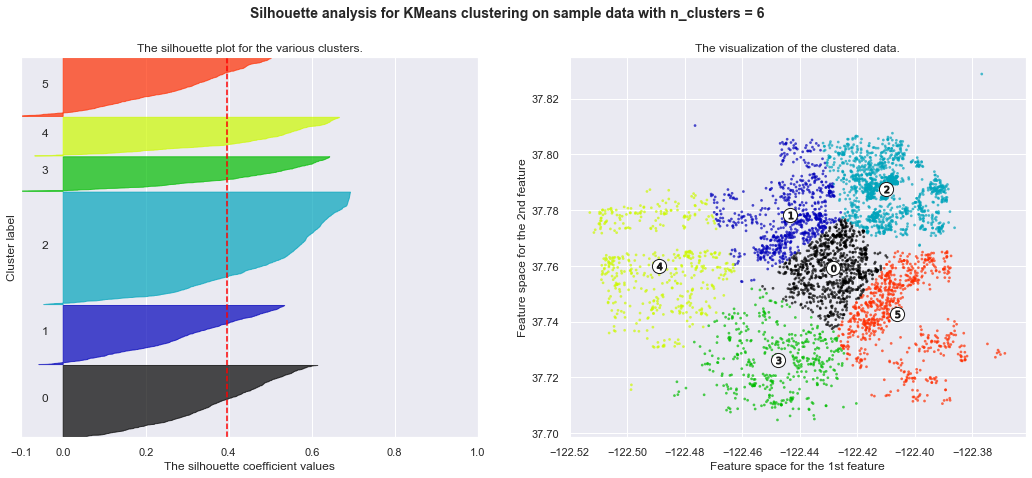

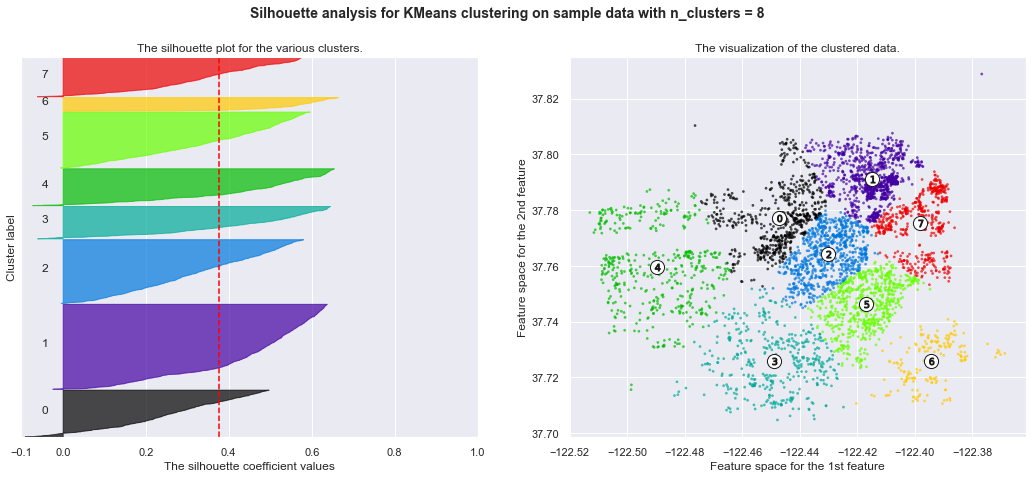

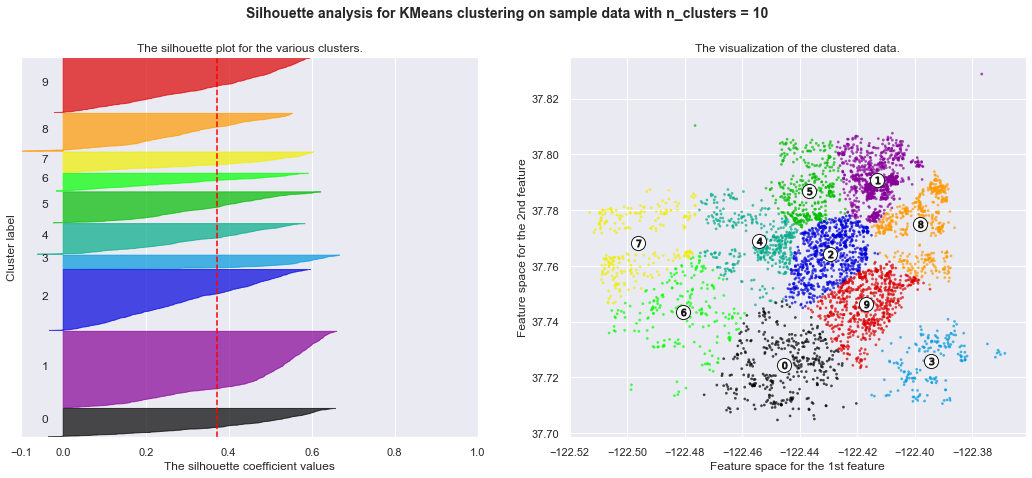

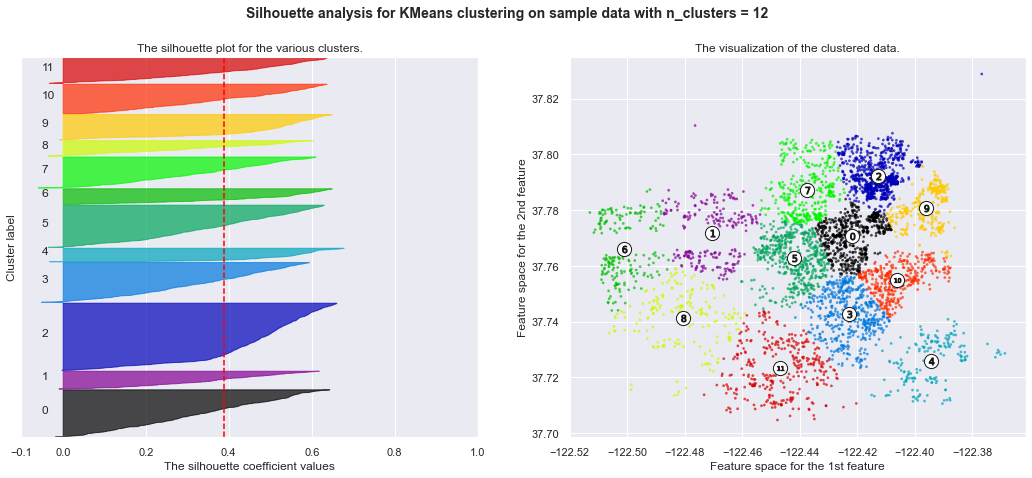

In [35]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

X = data[['longitude', 'latitude']].values
range_n_clusters = [2, 3, 4, 5, 6, 8 , 10, 12]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [36]:
n_clusters=12
clusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(X)

In [37]:
data['neighborhood'] = cluster_labels

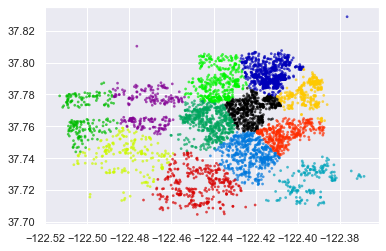

In [38]:
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
plt.scatter(
   data['longitude'], data['latitude'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)

In [39]:
del data['longitude']
del data['latitude']

#### 5.2 Group property types such as (camper/RV,  In-law, Earth house, Dome house, Hut, Bed and breakfast) to "others" 

In [40]:
data.loc[data['property_type'] == "Camper/RV", 'property_type'] = "Other"
data.loc[data['property_type'] == "In-law", 'property_type'] = "Other"
data.loc[data['property_type'] == "Earth house", 'property_type'] = "Other"
data.loc[data['property_type'] == "Dome house", 'property_type'] = "Other"
data.loc[data['property_type'] == "Hut", 'property_type'] = "Other"
data.loc[data['property_type'] == "Bed and breakfast", 'property_type'] = "Other"

In [41]:
data.property_type.unique()

array(['Apartment', 'House', 'Townhouse', 'Loft', 'Guest suite',
       'Condominium', 'Cottage', 'Guesthouse', 'Serviced apartment',
       'Bungalow', 'Other', 'Hotel', 'Hostel', 'Boutique hotel',
       'Tiny house', 'Aparthotel', 'Villa', 'Cabin'], dtype=object)

#### 5.3 Make Dummy variables

In [42]:
encoder = OneHotEncoder(handle_unknown="ignore")
encoder.fit(data[['property_type', 'room_type', 'neighborhood']])

OneHotEncoder(handle_unknown='ignore')

In [43]:
dummy_vars = encoder.transform(data[['property_type', 'room_type', 'neighborhood']])

In [44]:
X = data.copy(deep=True)
y = data['price']

In [45]:
del X['property_type']
del X['room_type']
del X['neighborhood']
del X['price']

In [46]:
X = np.concatenate((X, dummy_vars.toarray()),axis=1)
X.shape

(4579, 37)

In [47]:
y.shape

(4579,)

In [48]:
feature_names = ['bathrooms', 'bedrooms', 'minimum_nights'] + list(encoder.get_feature_names(['property_type', 'room_type', 'neighborhood']))
X = pd.DataFrame(data=X, columns = feature_names)

In [49]:
X

bathrooms  bedrooms  minimum_nights  property_type_Aparthotel  \
0           1.0       2.0            30.0                       0.0   
1           4.0       1.0            32.0                       0.0   
2           4.0       1.0            32.0                       0.0   
3           1.0       2.0            30.0                       0.0   
4           1.0       0.0            30.0                       0.0   
...         ...       ...             ...                       ...   
4574        1.0       0.0             2.0                       0.0   
4575        1.0       1.0             2.0                       0.0   
4576        1.0       1.0             2.0                       0.0   
4577        2.0       1.0            30.0                       0.0   
4578        1.0       1.0            30.0                       0.0   

      property_type_Apartment  property_type_Boutique hotel  \
0                         1.0                           0.0   
1                         1.0                           0.0   
2                         1.0                           0.0   
3                         0.0                           0.0   
4                         1.0                           0.0   
...                       ...                           ...   
4574                      1.0                           0.0   
4575                      0.0                           0.0   
4576                      0.0                           0.0   
4577                      0.0                           0.0   
4578                      1.0                           0.0   

      property_type_Bungalow  property_type_Cabin  property_type_Condominium  \
0                        0.0                  0.0                        0.0   
1                        0.0                  0.0                        0.0   
2                        0.0                  0.0                        0.0   
3                        0.0                  0.0                        0.0   
4                        0.0                  0.0                        0.0   
...                      ...                  ...                        ...   
4574                     0.0                  0.0                        0.0   
4575                     0.0                  0.0                        0.0   
4576                     0.0                  0.0                        0.0   
4577                     0.0                  0.0                        0.0   
4578                     0.0                  0.0                        0.0   

      property_type_Cottage  property_type_Guest suite  \
0                       0.0                        0.0   
1                       0.0                        0.0   
2                       0.0                        0.0   
3                       0.0                        0.0   
4                       0.0                        0.0   
...                     ...                        ...   
4574                    0.0                        0.0   
4575                    0.0                        0.0   
4576                    0.0                        1.0   
4577                    0.0                        0.0   
4578                    0.0                        0.0   

      property_type_Guesthouse  property_type_Hostel  property_type_Hotel  \
0                          0.0                   0.0                  0.0   
1                          0.0                   0.0                  0.0   
2                          0.0                   0.0                  0.0   
3                          0.0                   0.0                  0.0   
4                          0.0                   0.0                  0.0   
...                        ...                   ...                  ...   
4574                       0.0                   0.0                  0.0   
4575                       0.0                   0.0                  0.0   
4576                       0.0               

<a id="6"></a> <br>
<font color='black' size="+2.5"><b>6 - Modelling</b></font><br>

We will use an XGBRegressor as a model. Because our data have many categorical values a Tree model would work very well. XGBoost performs amazingly well most of the times and also we can interpret the results

The hyperparameter tuning will be done using Randomized Grid Search CV because it works better most of the time than GridSearchCV. This is because of a probability trick and understands the area of the grid that works better for the model

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, test_size=0.1,
                                                                random_state=0)

In [53]:
# A parameter grid for XGBoost
params = {
    'n_estimators':[10, 20, 30],
    'min_child_weight':[4], 
    'gamma':[i/10.0 for i in range(5,6)],  
    'subsample':[i/10.0 for i in range(10,11)],
    'colsample_bytree':[i/10.0 for i in range(10,11)], 
    'max_depth': [8],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(5,6)],
}

reg = XGBRegressor(nthread=-1, verbosity = 2)

# run randomized search
n_iter_search = 10
random_search = RandomizedSearchCV(reg, param_distributions=params,
                                   n_iter=n_iter_search, cv=5, scoring='neg_mean_squared_error')

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

[09:02:03] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:02:06] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:02:08] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
 

In [54]:
best_regressor = random_search.best_estimator_
y_pred = best_regressor.predict(X_test)

In [56]:
random_search.best_params_

{'subsample': 1.0,
 'objective': 'reg:squarederror',
 'n_estimators': 10,
 'min_child_weight': 4,
 'max_depth': 8,
 'gamma': 0.5,
 'eval_metric': 'rmse',
 'eta': 0.5,
 'colsample_bytree': 1.0,
 'booster': 'gbtree'}

In [55]:
rmse_pred = mean_absolute_error(y_test, y_pred) 
print("Root Mean Absolute Error:" , np.sqrt(rmse_pred))

Root Mean Absolute Error: 5.442505665278656


**Having an RMSE=5.44 dollars is very good considering that we only needed 338 seconds to train our model. With more hyperparameter tuning we could achieve better results. Although, as we see the number is less than 25 dollars and that means that people will not be discouraged**

### 6.1 Save model 

In [58]:
with open('model/randomized_search_results.pickle', 'wb') as handle:
    pickle.dump(random_search, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [59]:
with open('model/best_xgboostregressor.pickle', 'wb') as handle:
    pickle.dump(best_regressor, handle, protocol=pickle.HIGHEST_PROTOCOL)

<a id="7"></a> <br>
<font color='black' size="+2.5"><b>7 - Interpreting</b></font><br>

We will use SHAP values and xgboost tree interpreter to compare our results. Shap values are going to be more consistent probably and that's because the interpreter  has 3 different types of importance such as:

- cover: The number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.
- gain: The average training loss reduction gained when using a feature for splitting.
- weight:  The number of times a feature is used to split the data across all trees.

#### 7.1 Classic Feature Atributions

In [69]:
def my_plot_importance(booster, figsize, **kwargs): 
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

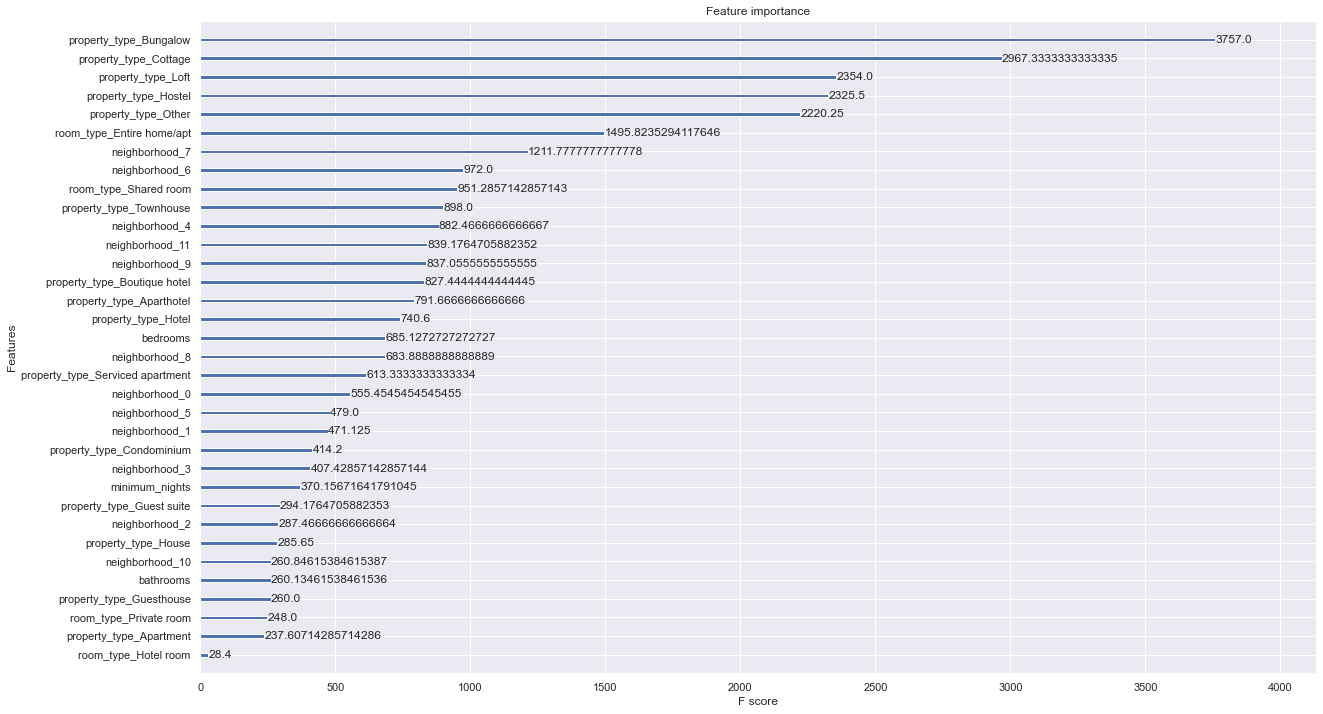

In [71]:
my_plot_importance(best_regressor, (20,12), importance_type="cover")

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

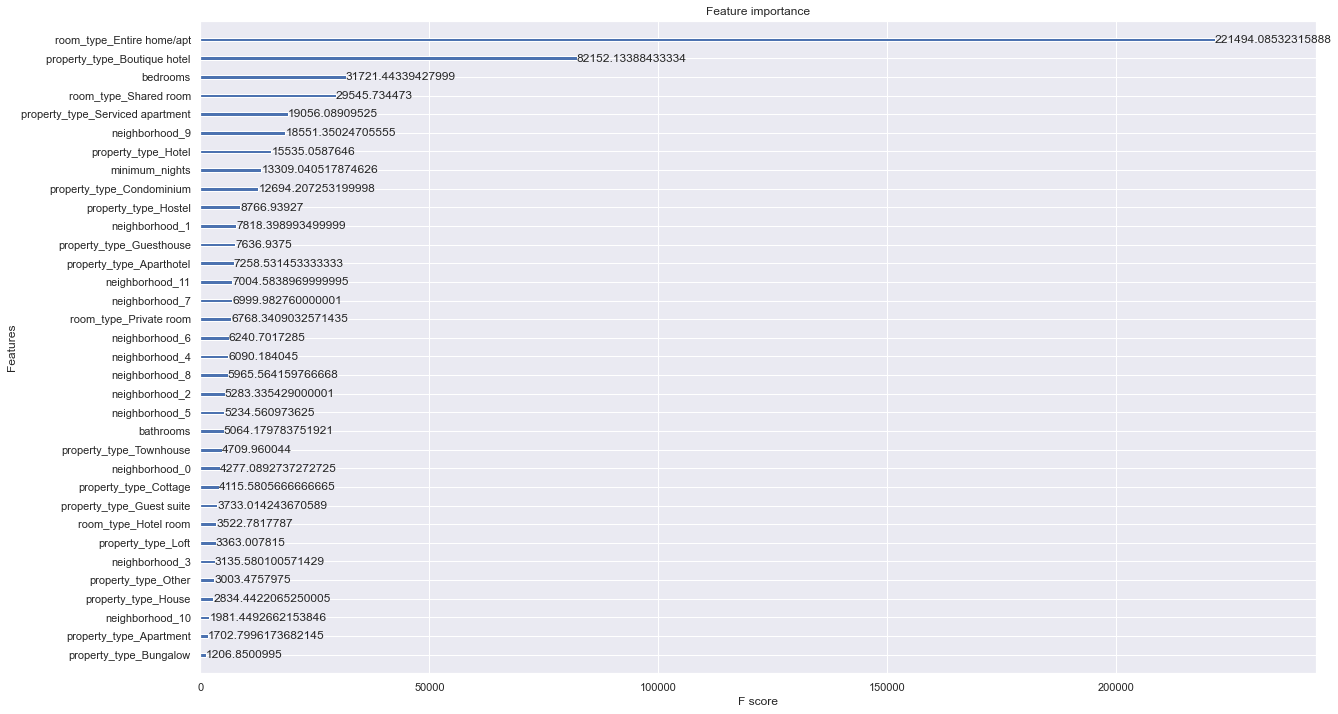

In [72]:
my_plot_importance(best_regressor, (20,12), importance_type="gain")

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

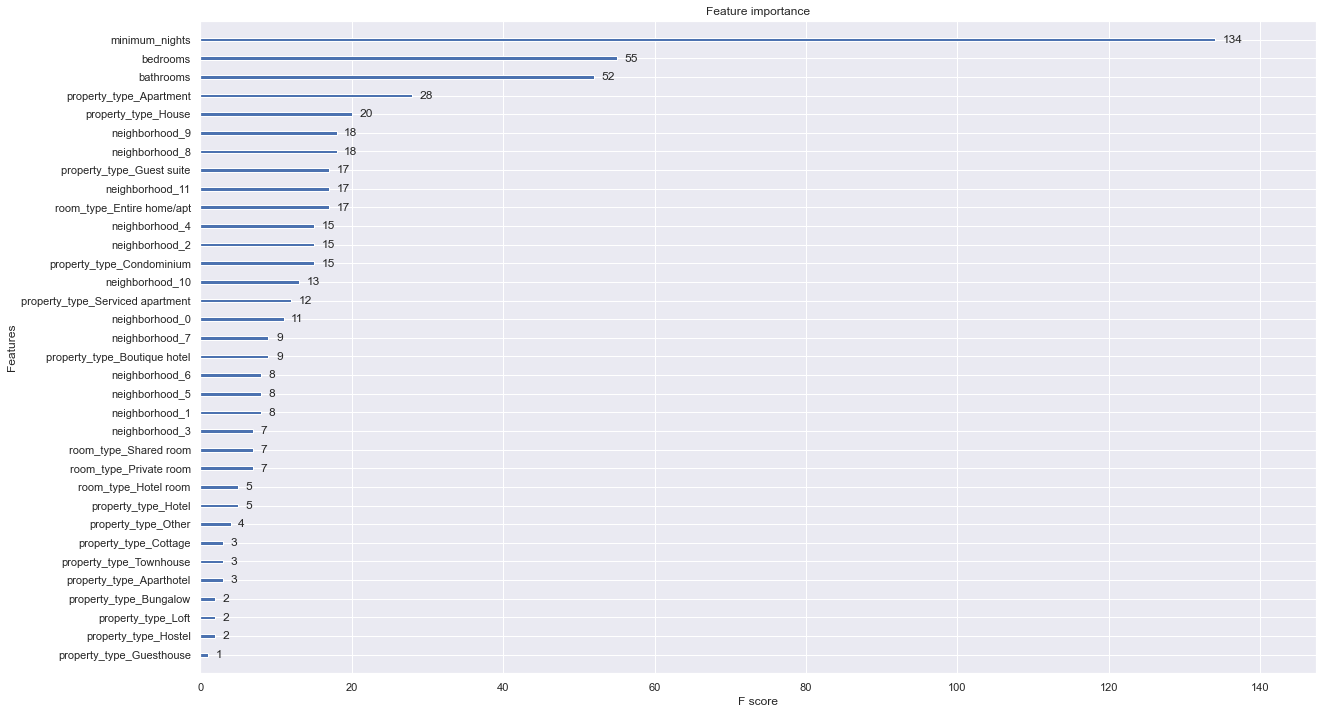

In [73]:
my_plot_importance(best_regressor, (20,12), importance_type="weight")

#### 7.2 Shap Values

In [76]:
explainer = shap.TreeExplainer(best_regressor)
shap_values = explainer.shap_values(X_test)

**Visualize a single prediction**

In [79]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

**Visualize Many predictions**

In [81]:
shap.force_plot(explainer.expected_value, shap_values, X_test)

**Bar Chart of mean importance**

This takes the average of SHAP value magnitudes across the dataset and plots it as a simple bar chart.

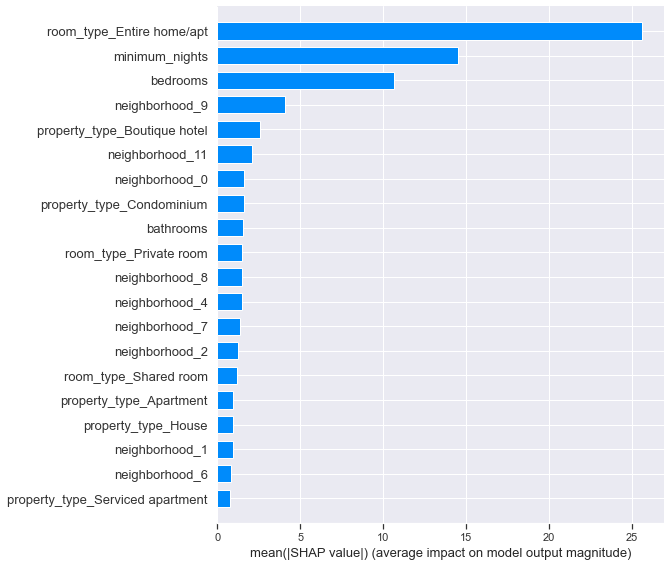

In [82]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

**SHAP Summary plot**

Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the relationship feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age. In other words, capital gain effects a few predictions by a large amount, while age effects all predictions by a smaller amount.

Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

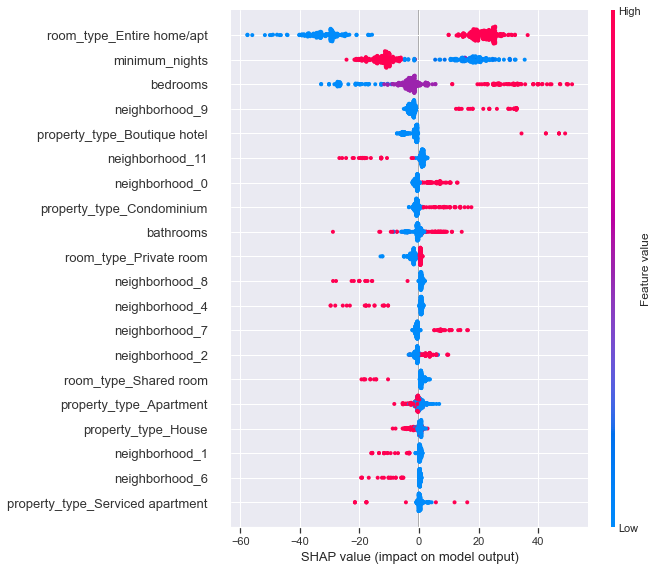

In [83]:
shap.summary_plot(shap_values, X_test)

**SHAP Dependence Plots**

SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

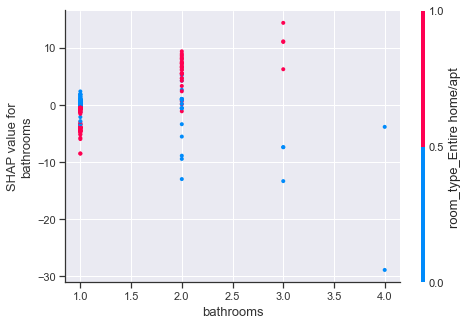

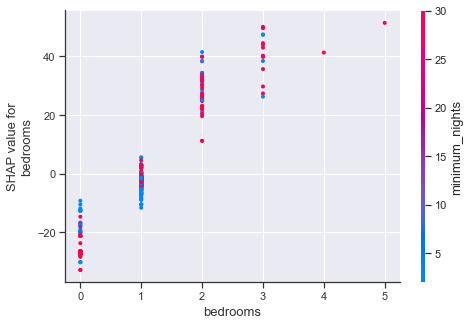

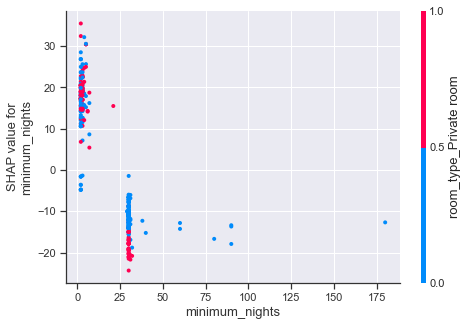

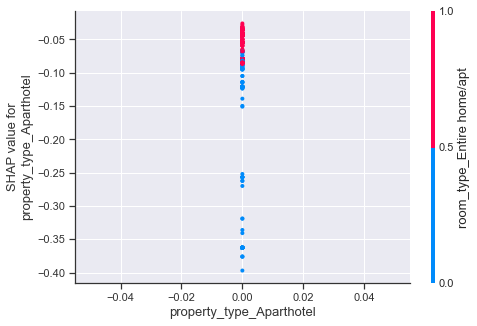

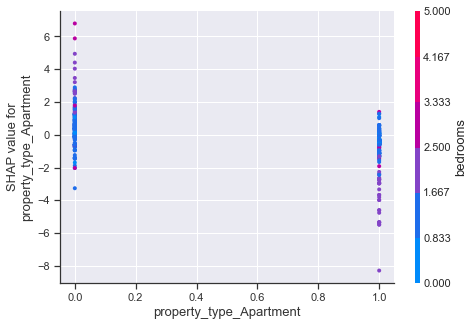

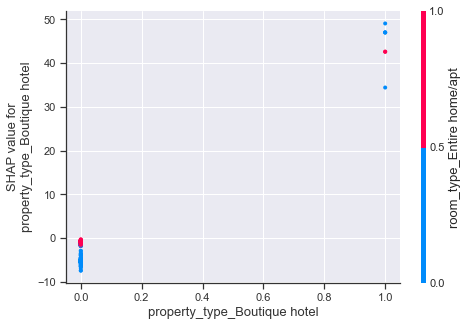

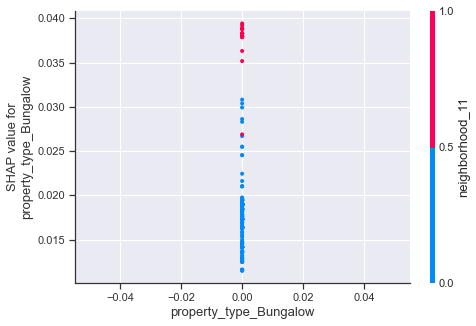

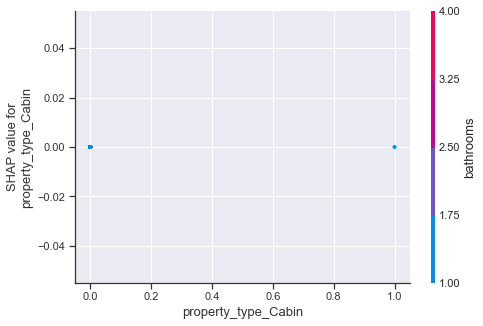

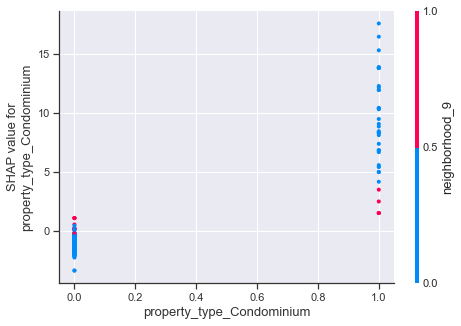

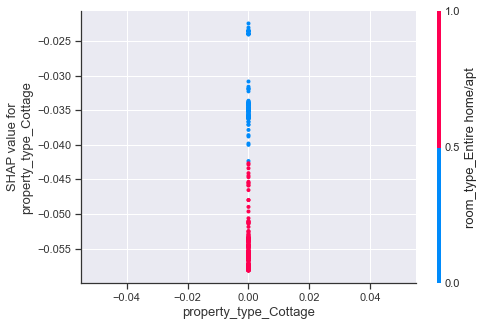

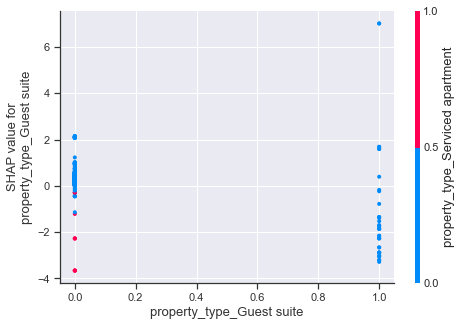

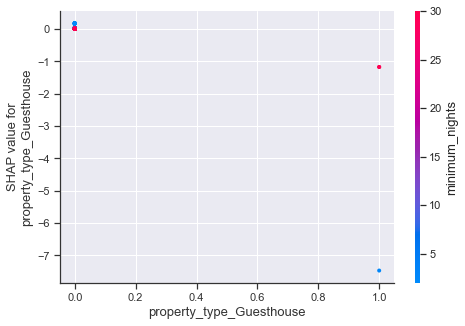

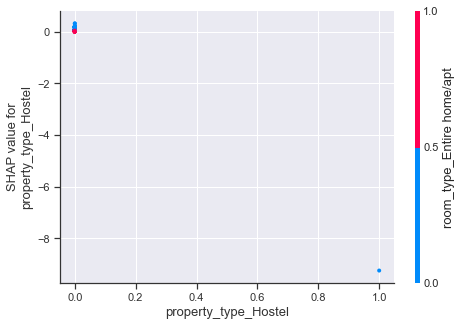

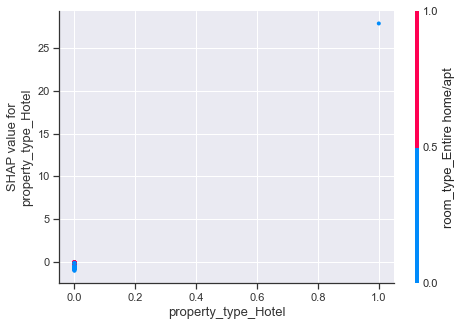

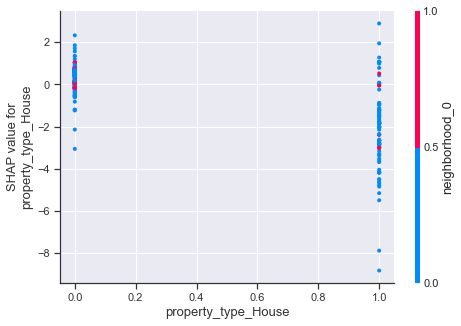

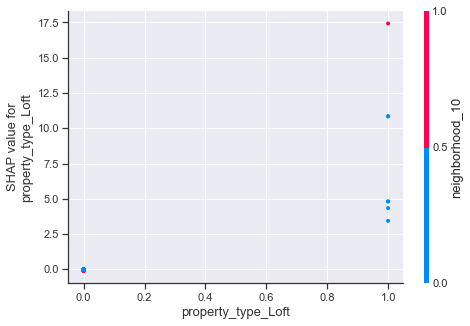

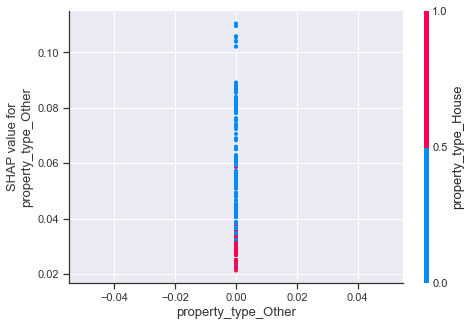

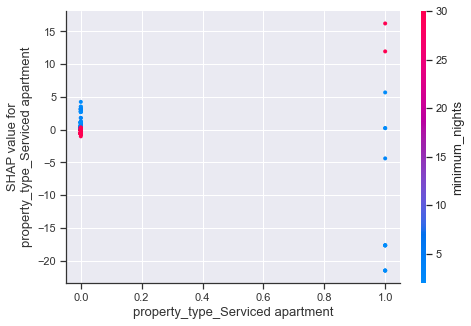

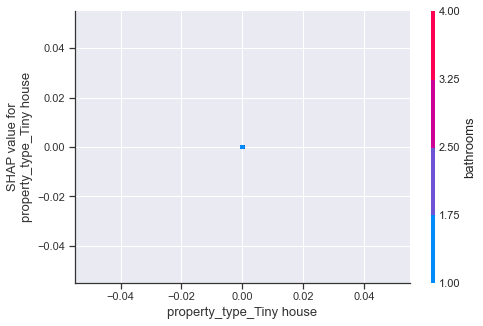

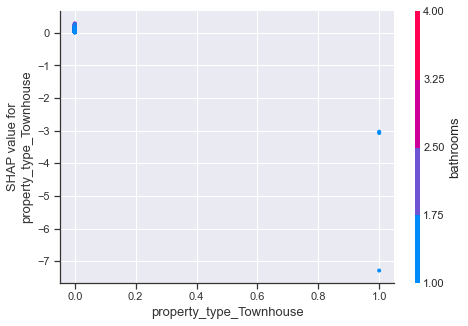

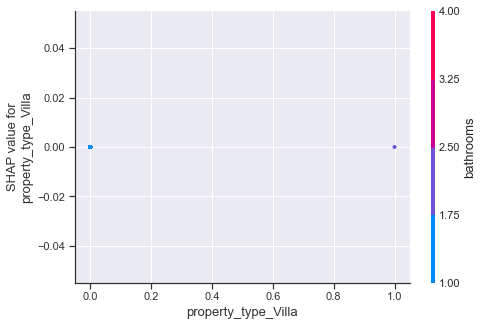

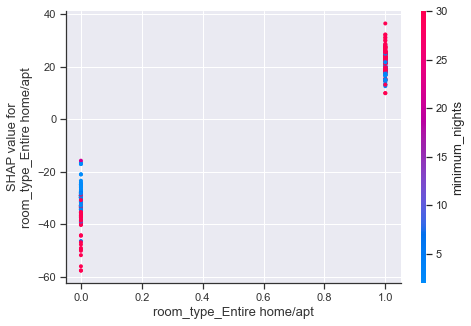

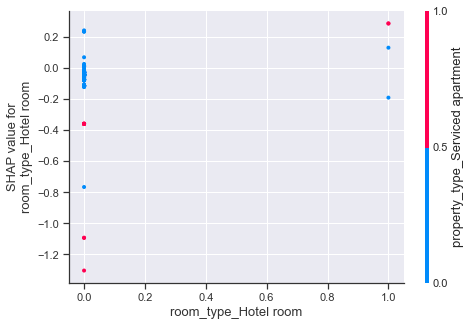

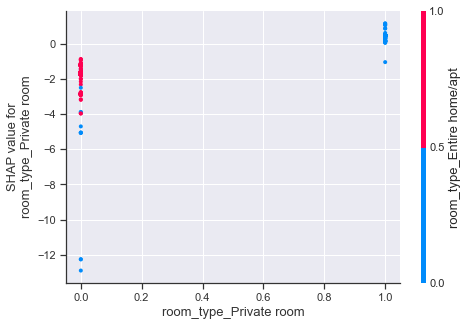

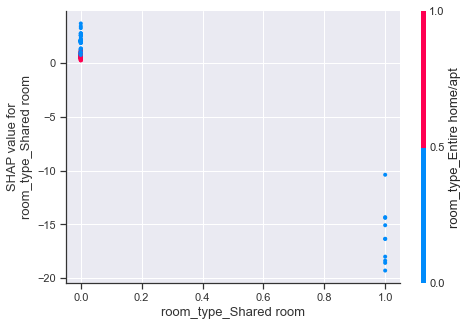

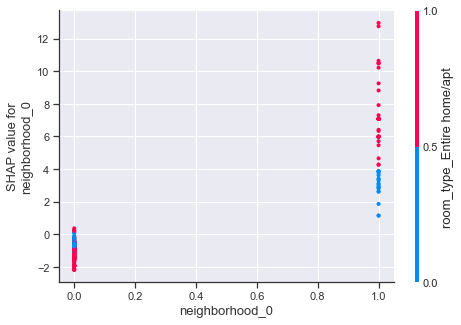

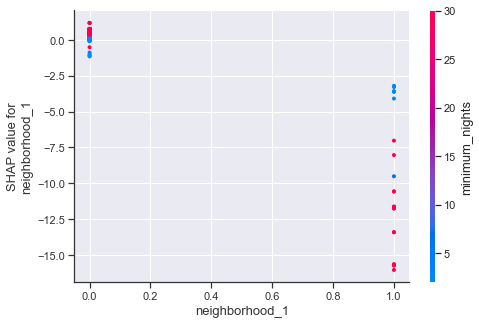

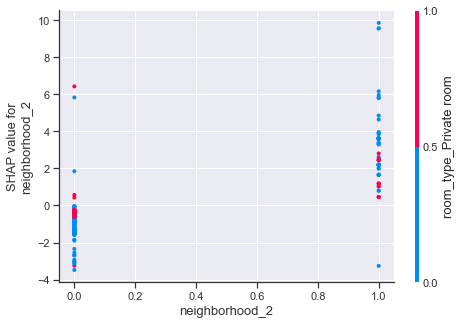

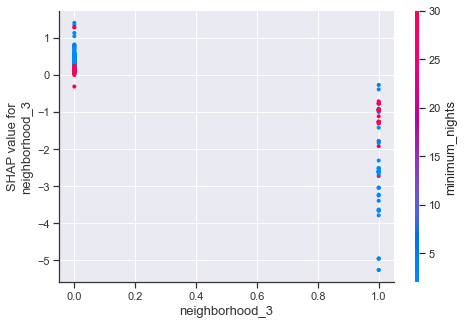

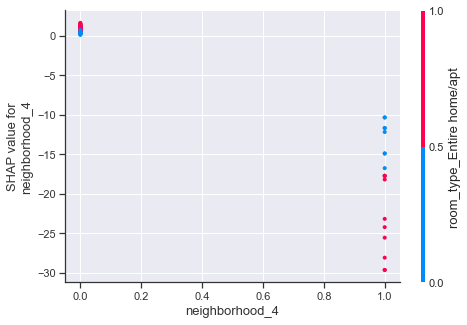

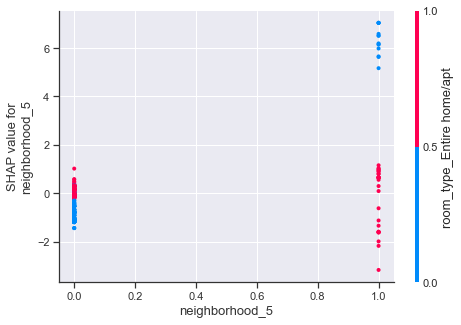

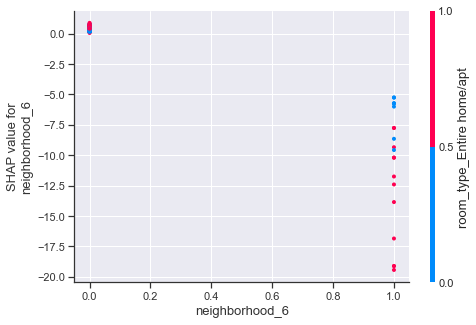

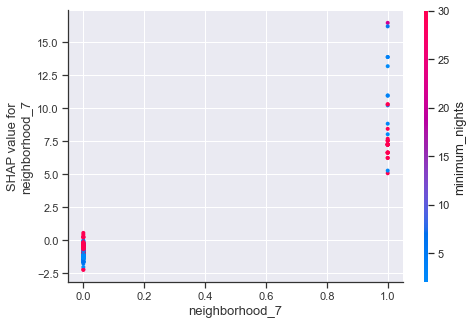

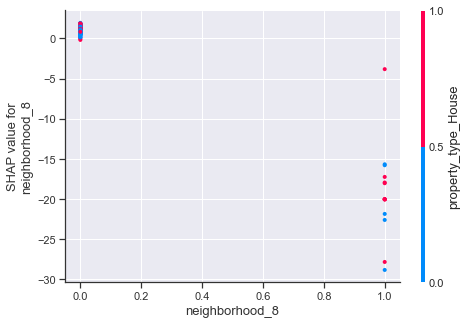

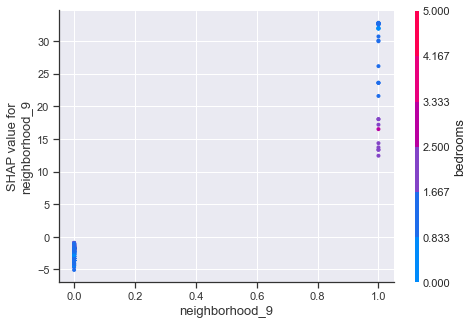

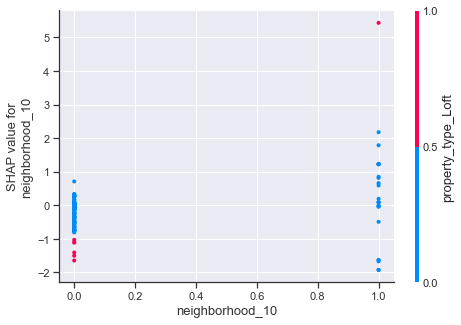

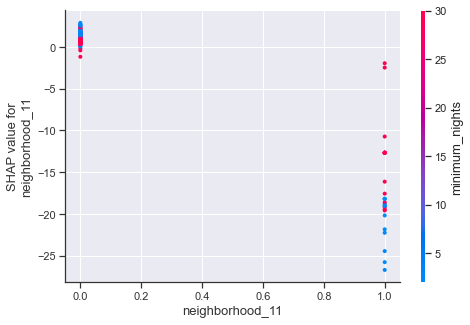

In [85]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_test, display_features=X_test)